# An analysis of the State of the Union speeches - Part 2

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve
import nltk # Please make sure to use nltk.download() to download collection 'popular'
nltk.download("popular") #Need to include this line in order to get some of the nltk functionality. Do not comment out.

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string


plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [16]:
# Read data from result created in p1
addresses = pd.read_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    speeches = db['speeches']

Let's double-check that we're getting the full set of speeches:

In [17]:
print(addresses.shape)
print(len(speeches))

(227, 3)
227


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [18]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

In [19]:
def clean_word_tokenize(doc):
    """custom word tokenizer which removes stop words and punctuation
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    stop = stopwords.words('english')  + list(string.punctuation)
    #We lower case the words since "Word" and "word" are the same.
    return [i.lower() for i in nltk.word_tokenize(doc) if i not in stop]




Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [20]:
def stem_word_tokenize(doc):
    stemmer = PorterStemmer()
    stop = stopwords.words('english')  + list(string.punctuation)
    return [stemmer.stem(word.lower()) for word in nltk.word_tokenize(doc) if word not in stop]

clean_words = [clean_word_tokenize(speech) for speech in speeches]
stemmed_words = [stem_word_tokenize(speech) for speech in speeches]
#flattens list of words in stemmed speeches to just a list and then makes it a set
speech_words = set(word for clean_speech in stemmed_words for word in clean_speech) 
speeches_cleaned = stemmed_words 


addresses["n_sent"] = [len(nltk.sent_tokenize(speech)) for speech in speeches]
addresses["n_words_all"] = [len(nltk.word_tokenize(speech)) for speech in speeches]
addresses["n_words"] = [len(clean_speech) for clean_speech in clean_words]
addresses["n_uwords"] = [len(set(clean_speech)) for clean_speech in clean_words]
addresses["n_swords"] = [len(set(stemmed_speech)) for stemmed_speech in stemmed_words]
addresses["n_chars"] = [len(i) for i in speeches]
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
0,George Washington,State of the Union Address,1790-01-08,24,1178,538,395,356,6753
1,George Washington,State of the Union Address,1790-12-08,40,1515,683,513,463,8455
2,George Washington,State of the Union Address,1791-10-25,60,2487,1136,731,626,14203
3,George Washington,State of the Union Address,1792-11-06,61,2298,1042,682,580,12764
4,George Washington,State of the Union Address,1793-12-03,56,2132,972,714,652,11696


Let's look at a summary of these 

In [21]:
pd.options.display.precision = 2
addresses.describe()

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,266.15,8305.68,4048.22,1639.81,1290.48,45474.77
std,178.80,5871.46,2900.45,747.67,508.09,33019.96
min,24.00,1059.00,538.00,395.00,356.00,5649.00
25%,165.00,4396.00,2190.50,1088.50,914.50,23394.50
50%,240.00,6655.00,3388.00,1530.00,1246.00,36677.00
75%,347.50,10055.00,4801.50,1998.50,1552.00,55211.00
max,1343.00,36974.00,21041.00,4282.00,3015.00,218009.00


Wow! The maximum number of words used in a speech was 21041 while the minimum number of words used was 538. That is quite a difference! Which two speeches were these?

In [28]:
print("Speech with max number of words")
print(addresses[addresses["n_words"] == addresses["n_words"].max()][["president", "date"]])
print()
print("Speech with min number of words")
print(addresses[addresses["n_words"] == addresses["n_words"].min()][["president", "date"]])


Speech with max number of words
        president       date
189  Jimmy Carter 1981-01-16

Speech with min number of words
           president       date
0  George Washington 1790-01-08


Jimmy Carter gave the longest speech while George Washington gave the shortest speech. When Carter took presidency, the United States was facing a lot of problems: From international problems such as the Cold War and the Iran hostage crisis to domestic problems such as the recovering economy, Carter sure had a lot in his plate! Meanwhile, Washington's was the first state of the union ever delivered, so it makes sense for it to be the shortest. 

## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

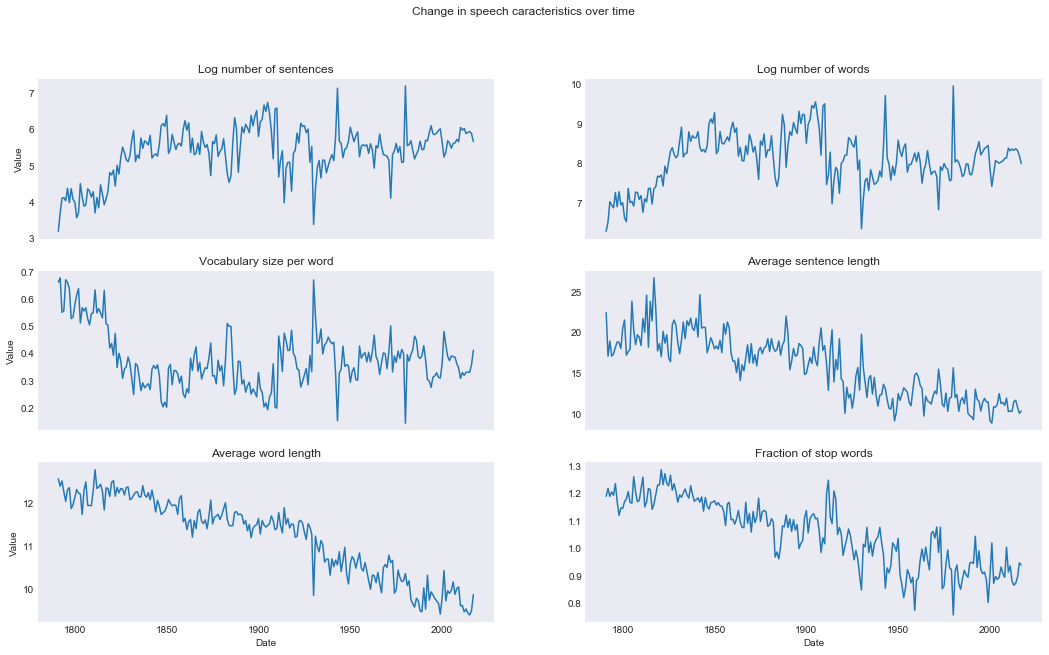

In [8]:
# Clean `addresses` to match the column name requirement in notebook 3
addresses["logn_words"], addresses["logn_sent"] = np.log(addresses["n_words"]), np.log(addresses["n_sent"])
addresses["vocab_per_word"] = addresses["n_swords"] / addresses["n_words"]
addresses["word_per_sent"] = addresses["n_words"] / addresses["n_sent"]
addresses["char_per_word"] = addresses["n_chars"] / addresses["n_words"]
addresses["frac_stop"] = addresses["n_words_all"] / addresses["n_words"] - 1

# `graph_data` is the cleaned data for graph
graph_data = addresses[["logn_sent", "logn_words", "vocab_per_word",
                          "word_per_sent", "char_per_word", "frac_stop"]]
graph_data.index = range(1791, 2018)

# Layout the plots
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 10), sharex = True)
fig.suptitle('Change in speech caracteristics over time')
 
# Define titles and sub-plot positions for each of the six categories 
titles = ['Log number of sentences', 'Log number of words', 'Vocabulary size per word', 'Average sentence length',
         'Average word length', 'Fraction of stop words']
positions = [axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1]]
# Create 6 plots using loop
for i in range(0, 6):
    ax = positions[i]
    ax.plot(graph_data.iloc[:,i], color = '#2479b5')
    ax.set_title(titles[i])
    ax.set_ylabel("Value")
    if(i in [1,3,5]): ax.set_ylabel('')
    if(i in [4, 5]): ax.set_xlabel('Date')
# Save the figure locally
plt.savefig("fig/speech_changes.png")

How interesting! Average word length, average sentence length, and the fraction of stop words have decreased over time, but at the same time, there seems to be an increasing trend in the log number of sentences and log number of words. This implies that as time passes, while presidents are speaking shorter sentences, they overall are speaking more sentences. This can be a result of the change in the English language over time.

Now for the distributions by president

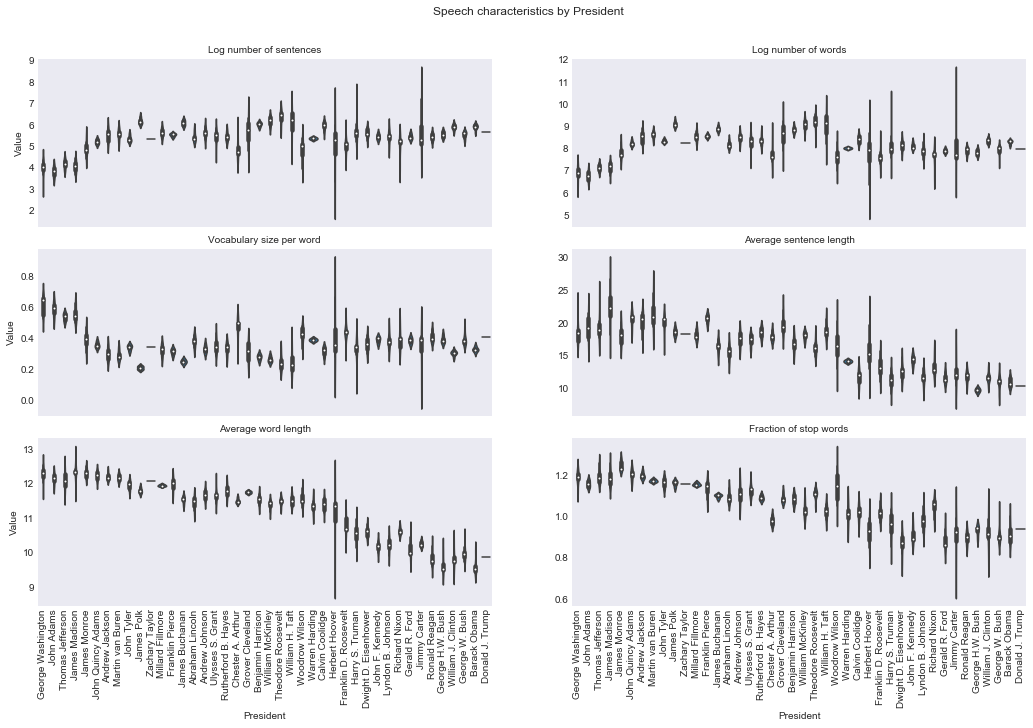

In [9]:
# Clean data
plot_data = addresses.drop(["title","date"], axis = 1)
plot_data["logn_sent"], plot_data["logn_words"] = np.log(plot_data["n_sent"]), np.log(plot_data["n_words"])
plot_data["vocsiz_word"] = plot_data["n_swords"] / plot_data["n_words"]
plot_data["avglen_sent"] = plot_data["n_words"] / plot_data["n_sent"]
plot_data["avglen_word"] = plot_data["n_chars"] / plot_data["n_words"]
plot_data["frac_stopword"] = plot_data["n_words_all"] / plot_data["n_words"] - 1 
plot_data = plot_data[["president", "logn_sent", "logn_words", "vocsiz_word",
                 "avglen_sent", "avglen_word", "frac_stopword"]]

# Melt data
plot_data = plot_data.melt("president")

# Title
title_dict = {"logn_sent": "Log number of sentences", "logn_words": "Log number of words", 
              "vocsiz_word": "Vocabulary size per word", "avglen_sent": "Average sentence length",
              "avglen_word": "Average word length", "frac_stopword": "Fraction of stop words"}
plot_data["title"] = [title_dict.get(i) for i in plot_data["variable"]]

# Initialize a grid of plots with an Axes for each
grid = sns.FacetGrid(plot_data, col="title", col_wrap=2, sharey = False, size = 3, aspect = 2.5)

# Draw a boxplot-like violinplot
grid.map(sns.violinplot, "president", "value").set_titles("{col_name}")
grid.set_xticklabels(rotation = 90)
grid.set_ylabels("Value")
grid.set_xlabels("President")
grid.fig.suptitle('Speech characteristics by President')
grid.fig.subplots_adjust(top=.9)
# Save the figure locally
plt.savefig("fig/speech_characteristics.png");

There are several interesting things that we see.
* Herbert Hoover's and Jimmy Carter's speeches heavily vary in style. Maybe they had different speech writers? Or maybe the onset of the Great Depression and the problems going on in the U.S. mentioned before respectively made them have to address these issues in theie speeches when these issues came up.
* James Madison liked to use long sentences compared to other presidents while George HW Bush liked to use short sentences.


## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [13]:
addresses.to_hdf('results/df2.h5', 'addresses')

with shelve.open('results/vars2') as db:
    db['speech_words'] = speech_words # will contain the set of unique, stemmed words for each speech
    db['speeches_cleaned'] = speeches_cleaned  # stemmed versions of each speech, without collapsing into unique word sets